<img src="sghlogo.png" alt="drawing" width="400"/>


# Statystyczne metody wielowymiarowej analizy porównawczej
# Projekt zaliczeniowy

Uladzislau Darhevich

Numer indeksu: ***108519***

email: ud108519@student.sgh.waw.pl

## Opis danych

Wydział Statystyki Organizacji Narodów Zjednoczonych (ang. *The United Nations Statistics Division*) w Departamencie Spraw Gospodarczych i Społecznych uruchomił nowy internetowy serwis danych dla globalnej społeczności użytkowników. Dzięki niemu statystyczne bazy danych ONZ są łatwo dostępne dla użytkowników poprzez pojedynczy punkt dostępu (http://data.un.org/). Użytkownicy mogą wyszukiwać i pobierać różne zasoby statystyczne systemu ONZ. 

Ten zbiór danych zawiera kluczowe wskaźniki statystyczne dla poszczególnych krajów. Obejmuje on 4 główne sekcje:

    - Informacje ogólne
    - Wskaźniki ekonomiczne
    - Wskaźniki społeczne
    - Wskaźniki środowiskowe i infrastrukturalne

Dane pochodzą z roku 2017, jeśli są dostępne, lub z najbardziej aktualnych danych sprzed roku. Ilość wskaźników - 62. Ilość krajów lub terytorium - 229.

## Hipoteza badawcza

Celem projektu jest podzielenie krajów świata na grupy w oparciu o ich wskaźniki społeczno-ekonomiczne.

Dla zmniejszenia liczby zmiennych zastosowano dwie metody:
- analiza głównych składowych (*ang. principal component analysis*, ***PCA***);
- analiza czynnikowa (*ang. factor analysis*, ***FA***).


Projekt wykorzystuje język Python i bibliotekш *Pandas*, *Scikit-learn* oraz inne.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation, SpectralClustering, KMeans, DBSCAN, AgglomerativeClustering
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns   
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

import pycountry
import geopandas

sns.set_theme(context='notebook', style='white', palette='bright')
SEED = 1234

In [2]:
df = pd.read_csv('../data/data_multidim/country_profile_variables.csv')

In [3]:
repalce_country_names = {
            'Bolivia (Plurinational State of)' : 'Bolivia, Plurinational State of',
            'British Virgin Islands' : 'Virgin Islands, British',
            'Channel Islands' : "Jersey",
            'China, Hong Kong SAR' : "Hong Kong",
            'China, Macao SAR': 'Macao',
            "Democratic People's Republic of Korea" : "Korea, Democratic People's Republic of",
            'Democratic Republic of the Congo' : "Congo, The Democratic Republic of the",
            'Holy See' : "Holy See (Vatican City State)",
            'Iran (Islamic Republic of)' : "Iran, Islamic Republic of",
            'Micronesia (Federated States of)' : "Micronesia, Federated States of",
            'Republic of Korea' : "Korea, Republic of",
             'Republic of Moldova' : "Moldova, Republic of",
             'Saint Helena' : "Saint Helena, Ascension and Tristan da Cunha",
             'State of Palestine': "Palestine, State of",
             'Swaziland' : "Eswatini",
             'The former Yugoslav Republic of Macedonia' : "North Macedonia",
             'United Republic of Tanzania' : "Tanzania, United Republic of",
             'United States of America': "United States",
             'United States Virgin Islands': "Virgin Islands, U.S.",
             'Venezuela (Bolivarian Republic of)': "Venezuela, Bolivarian Republic of",
             'Wallis and Futuna Islands' : "Wallis and Futuna"}
df['country'].replace(repalce_country_names, inplace=True)

Zbiór danych zawiera 229 wiersze, dotyczące różnych państw lub terytoriów. Przykład wiersza z danymi:

In [4]:
df.iloc[66,]

country                                                              Estonia
Region                                                        NorthernEurope
Surface area (km2)                                                     45227
Population in thousands (2017)                                          1310
Population density (per km2, 2017)                                      30.9
Sex ratio (m per 100 f, 2017)                                           88.2
GDP: Gross domestic product (million current US$)                      22460
GDP growth rate (annual %, const. 2005 prices)                           1.4
GDP per capita (current US$)                                         17112.0
Economy: Agriculture (% of GVA)                                          3.4
Economy: Industry (% of GVA)                                            27.4
Economy: Services and other activity (% of GVA)                         69.2
Employment: Agriculture (% of employed)                                  3.8

In [5]:
df = df.applymap(lambda x: np.nan if x == -99 else x)

In [6]:
list_of_cols = ['Surface area (km2)', 'GDP growth rate (annual %, const. 2005 prices)', 'Economy: Agriculture (% of GVA)',
            'Employment: Agriculture (% of employed)', 'Employment: Industry (% of employed)', 'Employment: Services (% of employed)',
            'Unemployment (% of labour force)', 'International trade: Exports (million US$)', 'International trade: Imports (million US$)',
            'International trade: Balance (million US$)', 'Balance of payments, current account (million US$)',
            'Population growth rate (average annual %)', 'Urban population growth rate (average annual %)', 'Fertility rate, total (live births per woman)',
            'Refugees and others of concern to UNHCR (in thousands)', 'Infant mortality rate (per 1000 live births',
            'Health: Physicians (per 1000 pop.)', 'Education: Government expenditure (% of GDP)', 'Mobile-cellular subscriptions (per 100 inhabitants)',
            'Mobile-cellular subscriptions (per 100 inhabitants).1', 'Pop. using improved sanitation facilities (urban/rural, %)','Threatened species (number)']

In [7]:
def col_to_numeric(col):
    col = col.apply(lambda x: np.nan if x == '-99' else x)
    col = pd.to_numeric(col, errors='coerce')
    return col

In [8]:
df[list_of_cols] = df[list_of_cols].apply(col_to_numeric)

In [9]:
list_of_cols_paired = ['Labour force participation (female/male pop. %)', 'Life expectancy at birth (females/males, years)', 'Population age distribution (0-14 / 60+ years, %)',
                      'International migrant stock (000/% of total pop.)', 'Education: Primary gross enrol. ratio (f/m per 100 pop.)',
                      'Education: Secondary gross enrol. ratio (f/m per 100 pop.)', 'Education: Tertiary gross enrol. ratio (f/m per 100 pop.)',
                      'Forested area (% of land area)', 'Energy supply per capita (Gigajoules)', 'Pop. using improved drinking water (urban/rural, %)']

In [10]:
def seperate_paired_columns(col, df):
    col = col.apply(lambda x: np.nan if x == '-99' else x)
    tmp = col.str.split('/', 1, expand=True)
    tmp.columns = [col.name + "_option_A", col.name + "_option_B"]
    tmp = tmp.apply(pd.to_numeric, errors='coerce')
    df[tmp.columns.to_list()] = tmp

In [11]:
df[list_of_cols_paired] = df[list_of_cols_paired].apply(seperate_paired_columns, df=df)

In [12]:
df = df.drop(list_of_cols_paired, axis=1)
df = df.drop(['Net Official Development Assist. received (% of GNI)'], axis=1)

In [13]:
country = df['country']
region = df['Region']
df_num = df.iloc[:, 2:]

Zbiór zawiera braki danych. Są zaznaczone jako `-99` lub `NaN`. Dla imputacji danych użyta metoda najbliższego sąsiada. Brakujące wartości każdej próbki są imputowane przy użyciu średniej wartości z $N$ najbliższych sąsiadów znalezionych w zbiorze treningowym. Dwie próbki są bliskie, jeśli cechy, których brakuje w żadnej z nich, są bliskie. Liczba sąsiednich próbek do wykorzystania w imputacji równa się 5. Wszystkie wartości w każdym sąsiedztwie są ważone jednakowo.

In [14]:
imputer = KNNImputer()
imputer.fit(df_num)
X_imputed = pd.DataFrame(imputer.transform(df_num), columns=df_num.columns)

Też zmienne numeryczne zostały znormalizowane, w wyniku czego zmienne uzyskują średnią wartość oczekiwaną zero i odchylenie standardowe jeden. 

In [15]:
scaler = StandardScaler()
scaler.fit(X_imputed)
X_transform = pd.DataFrame(scaler.transform(X_imputed), columns=X_imputed.columns)

## Wizualizacja

Przed rozpoczęciem analizy dane zostały wizualizowane. Poniżej znajdują się dwa wykresy.
1. metoda redukcji wymiarów t-SNE (*ang. T-distributed Stochastic Neighbor Embedding*) - jest to narzędzie do wizualizacji danych wysokowymiarowych. Przekształca podobieństwa między punktami danych na wspólne prawdopodobieństwa i próbuje zminimalizować dywergencję Kullbacka-Leiblera między wspólnymi prawdopodobieństwami niskowymiarowego osadzenia i danych wysokowymiarowych. Rezultat działania tej metody podany na lewym wykresie.
2. Na prawym wykresie przedstawiona wizualizacja zbioru danych z użyciem analizy głównych składowych.

W tym momencie nie widać żadnych wyraźnie widocznych klasterów.

In [16]:
tsne = TSNE(random_state=SEED, init='pca', n_jobs=-1)
X_tsne = tsne.fit_transform(X_transform)

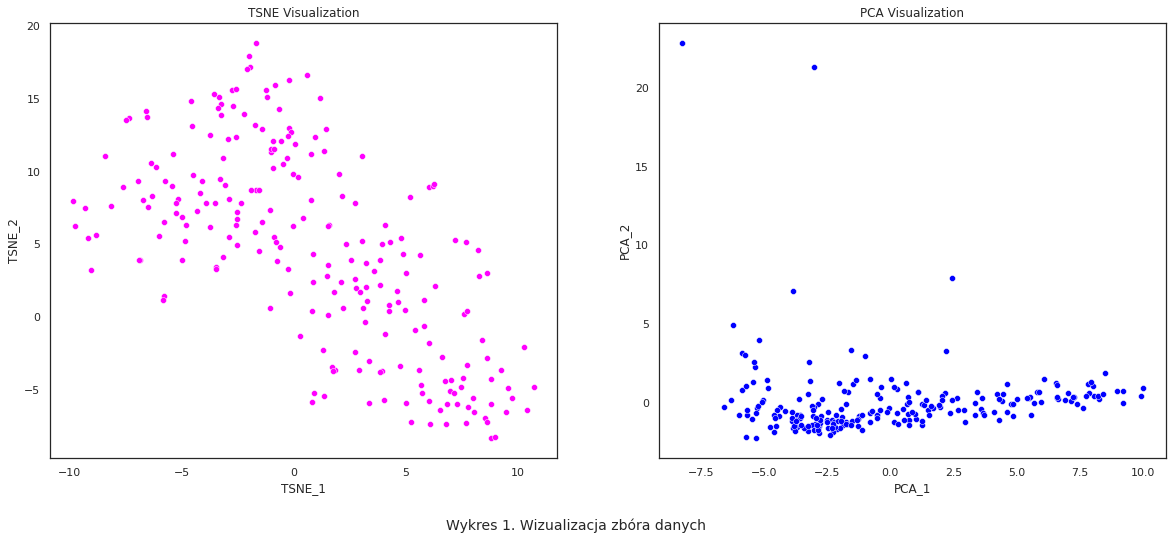

In [17]:
X_tsne = pd.DataFrame(X_tsne , columns=['TSNE_1', 'TSNE_2'])
pca = PCA(n_components=2, random_state=SEED)
pca.fit(X_transform)
X_pca = pca.transform(X_transform)
X_pca = pd.DataFrame(X_pca, columns=['PCA_1', 'PCA_2'])
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.scatterplot(data=X_tsne, x='TSNE_1', y='TSNE_2', ax=axes[0], color='magenta').set_title('TSNE Visualization')
sns.scatterplot(data=X_pca, x='PCA_1', y='PCA_2', ax=axes[1], color='blue').set_title('PCA Visualization')
_.text(0.4, 0, "Wykres 1. Wizualizacja zbóra danych",
            fontsize=14); 

## Analiza głównych składowych

Istotnym elementem wykorzystania analizy głównych składowych w praktyce jest umiejętność oszacowania, ile składowych jest potrzebnych do opisania danych. Można to określić patrząc na skumulowany współczynnik wyjaśnionej wariancji jako funkcję liczby składowych. Krzywa na wykresie niżej określa jak część całkowitej, 57-wymiarowej wariancji jest zawarta w pierwszych $N$ składowych. Na wykresie widać, ze jest potrzebne około 20 składowych, aby zachować **90%** wariancji. Spojrzenie na ten wykres dla wielowymiarowego zbioru danych może pomóc zrozumieć poziom redundancji.

In [18]:
pca = PCA(random_state=SEED)
pca.fit_transform(X_transform)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

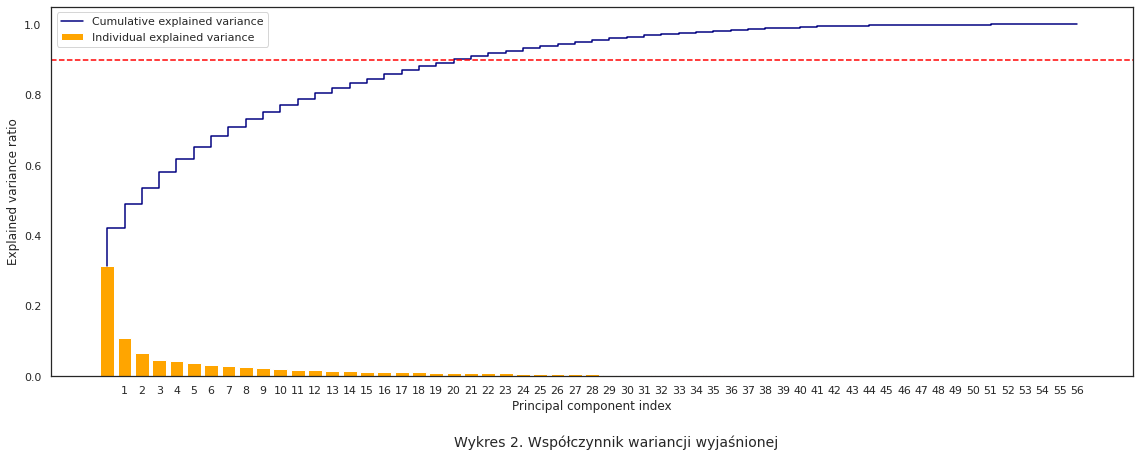

In [19]:
plt.figure(figsize=(16, 6)) 
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=1,
            align='center', color='orange',
            label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues,
            where='pre', color = 'navy',
            label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.xticks(np.arange(1, X_transform.shape[1], 1))
plt.legend(loc='best')
plt.tight_layout()
plt.axhline(y=0.9, color="red", linestyle='--')
plt.text(20, -0.2, "Wykres 2. Współczynnik wariancji wyjaśnionej",
            fontsize=14); 
plt.show();

In [20]:
pca = PCA(n_components = 20, random_state=SEED)
X_pca_tr = pca.fit_transform(X_transform)

## Analiza czynnikowa

Analiza czynnikowa jest jednym z nienadzorowanych algorytmów uczenia maszynowego, który jest używany do redukcji wymiarowości. Algorytm ten tworzy czynniki z obserwowanych zmiennych w celu reprezentacji wspólnej wariancji, tj. wariancji wynikającej z korelacji pomiędzy obserwowanymi zmiennymi.

Test Bartletta testuje hipotezę zerową, że wszystkie próbki wejściowe pochodzą z populacji o równych wariancjach. Jeśli wartość statystyki testu $p$ jest mniejsza niż 0.05, można zdecydować, że korelacja nie jest macierzą identyczną, tzn. korelacja występuje między zmiennymi z 95% poziomem ufności. Ponieważ statystyka $p$ testu jest mniejsza niż 0.05, można stwierdzić, że pomiędzy zmiennymi występuje korelacja, co jest sygnałem do zastosowania analizy czynnikowej.

In [21]:
chi2, p  = calculate_bartlett_sphericity(X_transform)
print(f"Chi squared = {round(chi2, 3)}, p-value ≈ {p}")

Chi squared = 19350.569, p-value ≈ 0.0


Test KMO (*ang. Kaiser–Meyer–Olkin test*) mierzy proporcję wariancji, która może być wspólną wariancją pomiędzy zmiennymi. Wynik KMO zawsze mieści się w przedziale od 0 do 1, Jest to miara tego, jak bardzo dane nadają się do analizy czynnikowej. Wyniki testu pokazują, że dane mają korelację i można zastosować techniki redukcji wymiarowości, takie jak analiza czynnikowa.

In [22]:
kmo_vars, kmo_model = calculate_kmo(X_transform)
print(f"Rezultat testu KMO wynosi {round(kmo_model, 3)}")

Rezultat testu KMO wynosi 0.852


Liczba czynników może być ustalona na podstawie ilości wspólnej wariancji, którą czynniki wyjaśniają. Wartości własne to ilość wariancji, którą wyjaśnia dany czynnik. Zostanie wybrana liczba czynników, których wartości własne są większe od 1.

W standardowym rozkładzie normalnym o średniej 0 i odchyleniu standardowym 1, wariancja będzie równa 1. Ponieważ użyte standardowo przeskalowane dane, wariancja cechy wynosi 1. Dlatego wybierano czynniki, których wartości własne (wariancja) są większe niż 1, tj. czynniki, które wyjaśniają więcej wariancji niż pojedyncza obserwowana zmienna.

Na podstawie wykresu 3 wybrano 12 czynników dla dalszej analizy.

In [23]:
fa = FactorAnalyzer(rotation = None, impute = "drop", n_factors=X_transform.shape[1])
fa.fit(X_transform)
ev,_ = fa.get_eigenvalues()

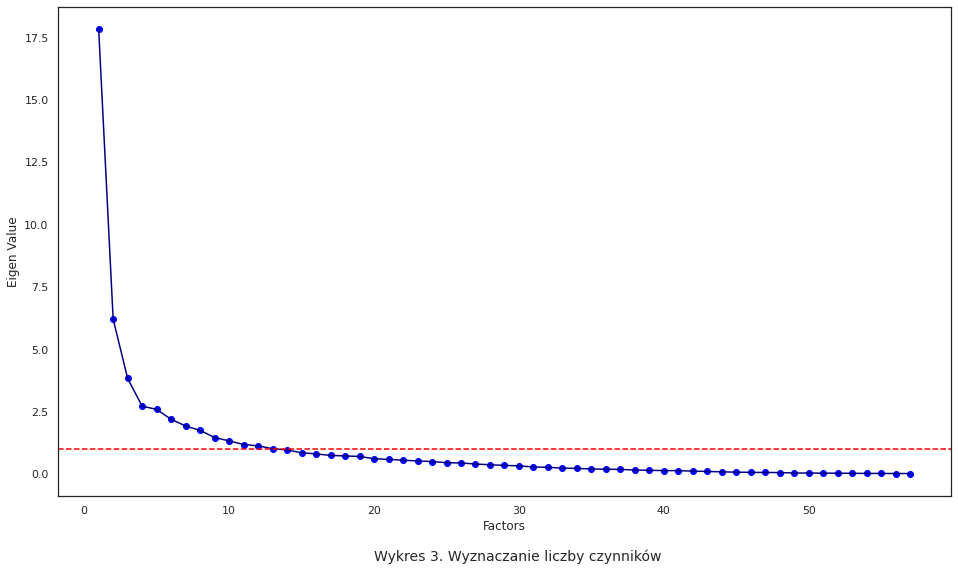

In [24]:
plt.figure(figsize=(16, 9))
plt.plot(range(1, X_transform.shape[1] + 1), ev, color='navy')
plt.scatter(range(1, X_transform.shape[1] + 1), ev, color='blue')
plt.ylabel('Eigen Value')
plt.xlabel('Factors')
plt.axhline(y=1, color="red", linestyle='--')
plt.text(20, -3.5, "Wykres 3. Wyznaczanie liczby czynników",
            fontsize=14);

Obciążenia wskazują, czy dobrze dany czynnik wyjaśnia daną zmienną. Wartości bliskie -1 lub 1 oznaczają, że czynnik ma wpływ na zmienne. Wartości bliskie 0 wskazują, że czynnik ma mniejszy wpływ na zmienną. W tabeli pokazany wartości dla pierwszych 10 zmiennych.

In [25]:
fa = FactorAnalyzer(n_factors=12, rotation='varimax')
fa.fit(X_transform)
X_fa_tr = fa.transform(X_transform)
pd.DataFrame(fa.loadings_, index=X_transform.columns).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
Surface area (km2),-0.004256,0.655471,0.026551,-0.078975,0.090371,-0.080701,-0.019327,-0.005504,-0.006574,0.007769,0.056156,-0.157835
Population in thousands (2017),-0.039332,0.728133,-0.083643,0.252580,0.073958,-0.073168,0.012854,-0.038240,-0.014682,-0.153057,-0.086504,0.093678
"Population density (per km2, 2017)",0.126534,-0.033565,0.037264,0.026360,-0.066709,0.038427,0.021625,0.037357,0.564393,0.004654,0.032314,0.003840
"Sex ratio (m per 100 f, 2017)",0.023712,-0.012609,0.748648,0.020430,0.020513,-0.063588,0.030676,-0.065217,-0.030715,-0.166931,-0.082488,0.202910
GDP: Gross domestic product (million current US$),0.101237,0.918821,0.025854,-0.264731,-0.033560,0.088360,-0.022195,0.007023,-0.005092,0.062416,0.004560,0.007721
"GDP growth rate (annual %, const. 2005 prices)",-0.039530,0.026565,-0.006716,0.037119,-0.019453,-0.039668,-0.029163,0.201616,-0.177085,-0.008399,-0.040190,0.214721
GDP per capita (current US$),0.484461,0.030607,0.289514,-0.026163,-0.081184,0.101046,-0.023669,0.203608,0.460758,0.158007,0.086311,-0.105490
Economy: Agriculture (% of GVA),-0.716025,-0.048547,-0.149081,0.017831,0.162149,0.316927,0.034852,0.010247,-0.063550,-0.073234,-0.375032,-0.004957
Economy: Industry (% of GVA),-0.123723,0.081610,0.274513,0.078290,0.116582,-0.666546,-0.027956,-0.233855,-0.220768,0.172215,-0.030487,-0.120314
Economy: Services and other activity (% of GVA),0.652477,-0.031531,-0.125666,-0.079966,-0.214273,0.347717,-0.005855,0.193384,0.250127,-0.102189,0.315004,0.118666


Na podstawie tabeli z warjacnją można zrobić wniosek, że 12 czynników łącznie mogą wyjaśnić **70.97%** całkowitej wariancji.

In [26]:
pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var'])

,0,1,2,3,4,5,6,7,8,9,10,11
Variance,16.386088,6.021422,3.027597,2.45326,2.177357,1.871355,1.855084,1.571374,1.559594,1.323851,1.138636,1.070007
Proportional Var,0.287475,0.105639,0.053116,0.04304,0.038199,0.032831,0.032545,0.027568,0.027361,0.023225,0.019976,0.018772
Cumulative Var,0.287475,0.393114,0.446230,0.48927,0.527469,0.560300,0.592845,0.620413,0.647774,0.671000,0.690976,0.709748


## Wyniki

Głowna różnica pomiędzy analizą głównych składowych (PCA) a analizą czynnikową polega na tym, że:

- PCA nie szacuje konkretnych efektów, więc po prostu znajduje matematyczną definicję "najlepszych" komponentów (komponentów, które maksymalizują wariancję);

- Analiza czynnikowa również oszacuje składowe, ale szacuje czynniki specyficzne. 

W analizie czynnikowej można zastosować rotacje do konkretnego rozwiązania, co pozwoli na znalezienie rozwiązania, które będzie miało bardziej spójną eksplikację biznesową do każdego z wyodrębnionych czynników.
Możliwość zastosowania rotacji w analizie czynnikowej sprawia, że jest ona doskonałym narzędziem do traktowania badań kwestionariuszowych w marketingu i psychologii.

PCA pozwala znaleźć składowe, które zawierają maksymalną ilość informacji w mniejszej ilości zmiennych. To czyni ją doskonałym narzędziem do redukcji wymiarów.PCA jest również szeroko stosowana w przygotowywaniu danych do zadań uczenia maszynowego.

Poniżej znajduje się porównanie, w jaki sposób oba modele wpłynęły na zdolność do grupowania krajów. Do grupowania stosuje się metodę K-średnich. Do określenia optymalnej liczby klastrów stosuje się metodę łokcia (*ang. elbow method*). Na wykresie 4 pokazano na jednej osi liczbę grup, a na drugiej sumę kwadratów odległości poszczególnych obserwacji od centroidów. Liczba grup, przy której jest widoczne znaczne załamanie spadku sumy kwadratów, równa się **7**.

In [27]:
inertia_pca = []
interia_fa = []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=SEED).fit(X_pca_tr)
    inertia_pca.append(np.sqrt(kmeans.inertia_))
    kmeans = KMeans(n_clusters=k, random_state=SEED).fit(X_fa_tr)
    interia_fa.append(np.sqrt(kmeans.inertia_))

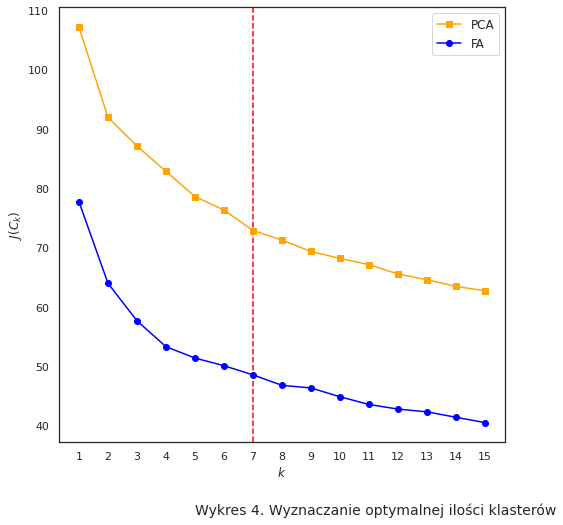

In [28]:
plt.figure(figsize=(8, 8)) 
plt.axvline(x=7, color="red", linestyle='--')
plt.plot(range(1, 16), inertia_pca, marker='s', color="orange", label='PCA');
plt.plot(range(1, 16), interia_fa, marker='o', color="blue", label='FA');
plt.xticks(np.arange(1, 16, 1))
plt.legend(prop={'size': 12})
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
plt.text(5, 25, "Wykres 4. Wyznaczanie optymalnej ilości klasterów",
            fontsize=14);

Poniższa tabela przedstawia wyniki oceny jakości metody k-średnich. Dla dalszej analizy wybieramy zbiór po transformacji PCA.

In [29]:
#other algorithms and metrics
N_CLUSTERS = 7
labels_pca = KMeans(n_clusters=N_CLUSTERS, random_state=SEED).fit(X_pca_tr).labels_
labels_fa = KMeans(n_clusters=N_CLUSTERS, random_state=SEED).fit(X_fa_tr).labels_

In [30]:
data = []
data.append(({
        'Silhouette Score': metrics.silhouette_score(X_pca_tr, labels_pca, random_state=SEED), 
        'Calinski-Harabasz Score': metrics.calinski_harabasz_score(X_pca_tr, labels_pca),
        'Davies-Bouldin Score': metrics.davies_bouldin_score(X_pca_tr, labels_pca)}))
data.append(({
        'Silhouette Score': metrics.silhouette_score(X_fa_tr, labels_fa, random_state=SEED), 
        'Calinski-Harabasz Score': metrics.calinski_harabasz_score(X_fa_tr, labels_fa),
        'Davies-Bouldin Score': metrics.davies_bouldin_score(X_fa_tr, labels_fa)}))
results = pd.DataFrame(data=data, columns=['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'],
                       index=['Principal Component Analysis', 'Factor Analysis'])
results

,Silhouette Score,Calinski-Harabasz Score,Davies-Bouldin Score
Principal Component Analysis,0.142223,42.960063,1.330957
Factor Analysis,0.115812,57.794143,1.285723


In [31]:
final_model_k_means = KMeans(n_clusters=N_CLUSTERS, random_state=SEED)
final_model_k_means.fit(X_pca_tr)
labels = final_model_k_means.labels_

Do przedstawionej wcześniej wizualizacji zbioru danych dodany etykiety przypisane metodą k-średnich.

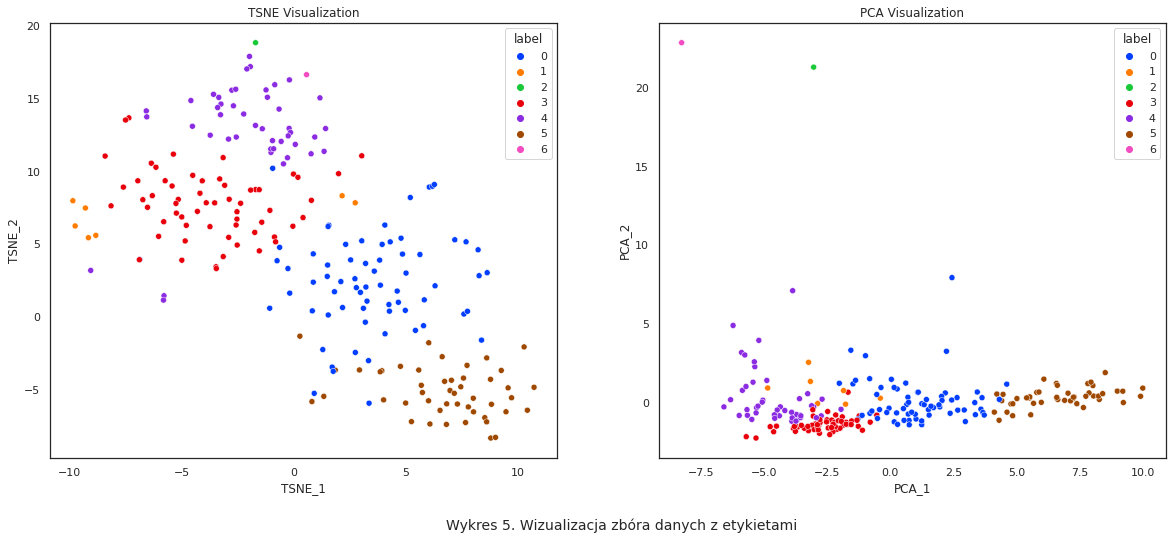

In [32]:
X_pca['label'] = labels
X_pca['country'] = country
X_pca['region'] = region
X_tsne['label'] = labels
X_tsne['country'] = country
X_tsne['region'] = region
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.scatterplot(data=X_tsne, x='TSNE_1', y='TSNE_2', hue='label',
                ax=axes[0], palette='bright').set_title('TSNE Visualization');
sns.scatterplot(data=X_pca, x='PCA_1', y='PCA_2', hue='label',
                ax=axes[1], palette='bright').set_title('PCA Visualization')
_.text(0.4, 0, "Wykres 5. Wizualizacja zbóra danych z etykietami",
            fontsize=14); 

In [33]:
df['label'] = labels

In [34]:
def get_alpha_3(col):
    countries = {}
    for country in pycountry.countries:
        countries[country.name] = country.alpha_3
    return [countries.get(country, 'Unknown code') for country in col]

In [35]:
df['alpha_3'] = get_alpha_3(df['country'])

In [36]:
world = geopandas.read_file('../data/data_multidim/ne_10m_admin_0_countries.zip')

In [37]:
df_map = df[['country', 'alpha_3', 'label']]
world_map = pd.merge(world, df_map, how='inner', left_on=['GU_A3'], right_on=['alpha_3'])

Wizualizacja etykiet na mapie świata.

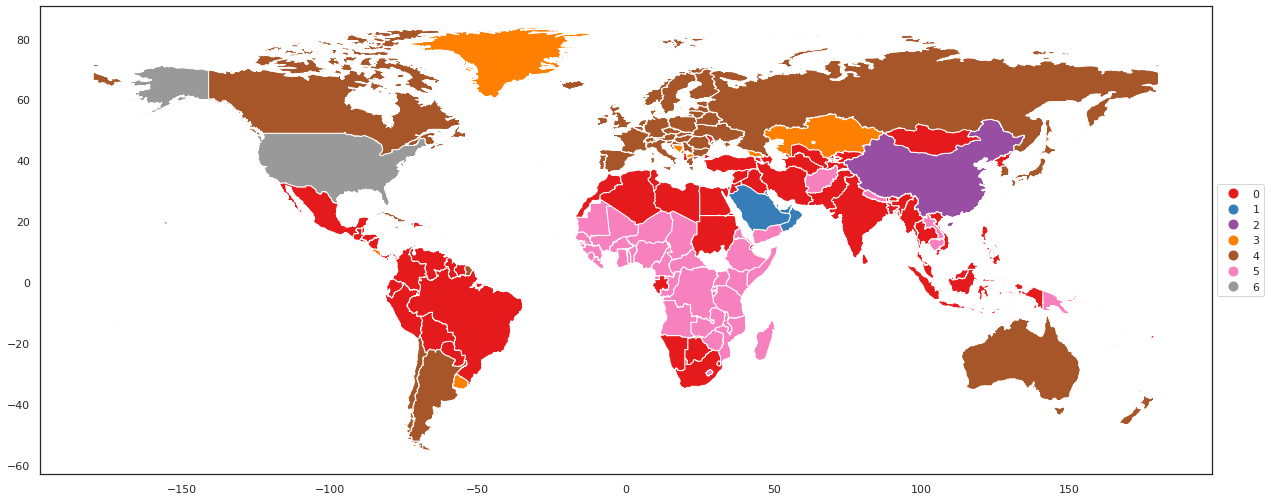

In [38]:
world_map.plot(figsize=(21, 15),
               column='label',
               cmap='Set1',
               legend=True,
               categorical=True,
               legend_kwds={'loc': 'center left',
                            'bbox_to_anchor':(1, 0.5)}
                  );

## Literatura

1. Radhika. (2020, December 29). Dimensionality Reduction using Factor Analysis (Python Implementation). Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/10/dimensionality-reduction-using-factor-analysis-in-python/
2. Kumar, A. (2020, August 8). PCA Explained Variance Concepts with Python Example. Data Analytics. https://vitalflux.com/pca-explained-variance-concept-python-example/
3. Korstanje, J. (2021, December 23). What is the difference between PCA and Factor Analysis? Medium. https://towardsdatascience.com/what-is-the-difference-between-pca-and-factor-analysis-5362ef6fa6f9

In [39]:
#conversion to html and pdf
!jupyter nbconvert project_multidim.ipynb --to pdf --no-input;
!jupyter nbconvert project_multidim.ipynb --to html;

[NbConvertApp] Converting notebook project_multidim.ipynb to pdf
[NbConvertApp] Support files will be in project_multidim_files/
[NbConvertApp] Making directory ./project_multidim_files
[NbConvertApp] Making directory ./project_multidim_files
[NbConvertApp] Making directory ./project_multidim_files
[NbConvertApp] Making directory ./project_multidim_files
[NbConvertApp] Making directory ./project_multidim_files
[NbConvertApp] Making directory ./project_multidim_files
[NbConvertApp] Writing 40937 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 375128 bytes to project_multidim.pdf
[NbConvertApp] Converting notebook project_multidim.ipynb to html
[NbConvertApp] Writing 1133861 bytes to project_multidi